In [1]:
import torch
import torch.nn as nn
import numpy as np

In [ ]:
#from IPython.core.display import display, HTML #this is just for display
#display(HTML("<style>.container { width:100% !important; }</style>")) #this is just for display

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dtype = torch.float
slope = 25

In [3]:
class MIF(nn.Module):

    def __init__(
        self,
        R_on = 1000,
        R_off = 100000,
        v_on = 110,
        v_off = 5,
        tau = 100,
        tau_alpha = 100,
        E1 = 0,
        E2 = 50,
        C = 100 * 10**(-6),
        k_th = 0.6 * 25,
        
    ):
        super(MIF, self).__init__()

        self.R_on = R_on
        self.R_off = R_off
        self.v_on = v_on
        self.v_off = v_off
        self.tau = tau
        self.tau_alpha = tau_alpha
        self.E1 = E1
        self.E2 = E2
        self.C = C
        self.k_th = k_th


    def forward(self, _input, x1, x2, G1, G2, a, I, v):
        a = -a/self.tau_alpha + _input
        I = (a-I)/self.tau_alpha + I
        v = (I-G1*(v-self.E1)-G2*(v-self.E2))/self.C + v
        x1 = 1/self.tau*( (1-x1)/(1+torch.exp((self.v_on-(v-self.E1))/self.k_th)) - x1/(1+torch.exp(((v-self.E1)-self.v_off)/self.k_th))) + x1 #v[t] or v[t+1] both fine
        x2 = 1/self.tau*( (1-x2)/(1+torch.exp((self.v_on-(v-self.E2))/self.k_th))  -   x2/(1+torch.exp(((v-self.E2)-self.v_off)/self.k_th))  ) + x2 #v[t] or v[t+1] both fine
        G1 = x1/self.R_on + (1-x1)/self.R_off
        G2 = x2/self.R_on + (1-x2)/self.R_off

        return x1, x2, G1, G2, a, I, v


    def init_MIF(self, batch_size, *args):
        """Used to initialize x1, x2, G1, G2, a, I
        *args are the input feature dimensions.
        E.g., ``batch_size=128`` and input feature of size=1x28x28 would require ``init_stein(128, 1, 28, 28)``."""
        x1 = torch.ones((batch_size, *args), device=device, dtype=dtype) * 0.0238
        x2 = torch.ones((batch_size, *args), device=device, dtype=dtype) * 0.0238
        G1 = x1 / self.R_on + (1-x1)/self.R_off
        G2 = x2 / self.R_on + (1 - x2)/self.R_off
        #v = (self.E1 + self.E2)/2
        v = torch.ones((batch_size, *args), device=device, dtype=dtype) * (self.E1 + self.E2)/2
        I = torch.zeros((batch_size, *args), device=device, dtype=dtype)
        a = torch.ones((batch_size, *args), device=device, dtype=dtype) * 0.005

        return x1, x2, G1, G2, a, I, v

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import itertools
import matplotlib.pyplot as plt
#from mif import MIF

In [7]:
# Network Architecture
num_inputs = 28*28
num_hidden = 100
num_outputs = 10

# Training Parameters
batch_size=1
data_path='./data'

# Temporal Dynamics
num_steps = 1000

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [8]:
# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

In [9]:
mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/Users/ZP/opt/anaconda3/envs/py36/lib/python3.6/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [10]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(num_hidden,num_outputs)
        self.relu2 = nn.ReLU()
        self.mif1 = MIF()

    def forward(self, x):

        # Initialize hidden states and outputs at t=0
        x1, x2, G1, G2, a, I, v = self.mif1.init_MIF(batch_size, num_outputs)       

        # Record the final layer
        v_rec = []
        I_rec = []
        
        z = torch.zeros((1,10))
        for step in range(num_steps):
            
            out = self.fc1(x)
            out = self.relu1(out)
            out = self.fc2(out)
            out = self.relu2(out)
            
            if step in [0, 500]:
                x1, x2, G1, G2, a, I, v = self.mif1(out, x1, x2, G1, G2, a, I, v)

            else:
                x1, x2, G1, G2, a, I, v = self.mif1(z, x1, x2, G1, G2, a, I, v)
        
        #first way is normalize x  -- not work for 2 layer
        #second if statement z = torch.zeros(x.size(...784...)) or x
        #third is rate encoding rather than DC input

            v_rec.append(v)
            I_rec.append(I)
            
            #if step%100==0 and step>0:
             #   print('step:', step, 'voltage:', v_rec)
             #   print('step:', step, 'current:', I_rec)

        return torch.stack(v_rec, dim=0), torch.stack(I_rec, dim=0)

In [11]:
def print_batch_accuracy(data, targets, train=False):
    v_rec, _ = net(data.view(batch_size, -1)) # T x B x 10
    #print('v_rec shape:', v_rec.shape)
    t_max, _ = v_rec.max(dim=0) # find max for each time-dim # find max value for one MIF neuron through time
    #print('t_max', t_max, 't_max.shape', t_max.shape)
    _, idx = t_max.max(dim=-1) # find max for each neuron index # find max value for all MIF neurons
    #print('idx', idx, 'idx.shape', idx.shape)
    acc = np.mean((targets == idx).detach().cpu().numpy())
    #acc = np.mean((targets == idx).detach().cuda().numpy()) 

    if train:
        print(f"Train Set Accuracy: {acc}")
    else:
        print(f"Test Set Accuracy: {acc}")

def train_printer():
    print(f"Epoch {epoch}, Minibatch {minibatch_counter}")
    print(f"Train Set Loss: {loss_hist[counter]}")
    print(f"Test Set Loss: {test_loss_hist[counter]}")
    print_batch_accuracy(data_it, targets_it, train=True)
    print_batch_accuracy(testdata_it, testtargets_it, train=False)
    print("\n")

In [12]:
net = Net().to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=1e-4, betas=(0.9, 0.999))
log_softmax_fn = nn.LogSoftmax(dim=-1)
#sigmoid_fn = nn.Sigmoid(dim=-1)
loss_fn = nn.NLLLoss()

loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(3):
    minibatch_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data_it, targets_it in train_batch:
        data_it = data_it.to(device)
        targets_it = targets_it.to(device)

        v_rec, I_rec = net(data_it.view(batch_size, -1))
        #print(v_rec.size())
        log_p_y = log_softmax_fn(v_rec) #[1000, 10] in 10 neuron dimension (0-1)
        #log_p_y = sigmoid_fn(v_rec)
        loss_val = torch.zeros((1), dtype=dtype, device=device)

        # Sum loss over time steps: BPTT
        for step in range(num_steps):
            loss_val += loss_fn(log_p_y[step], targets_it)
        
        # applied torch.max to time domain ,then activation function, then compare with target
        # input time
        # max in time, domain, 

        # Gradient calculation
        optimizer.zero_grad()
        loss_val.backward()

        # Weight Update
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        test_data = itertools.cycle(test_loader)
        testdata_it, testtargets_it = next(test_data)
        testdata_it = testdata_it.to(device)
        testtargets_it = testtargets_it.to(device)

        # Test set forward pass
        test_v, test_I = net(testdata_it.view(batch_size, -1))

        # Test set loss
        log_p_ytest = log_softmax_fn(test_v)
        log_p_ytest = log_p_ytest.sum(dim=0)
        loss_val_test = loss_fn(log_p_ytest, testtargets_it)
        test_loss_hist.append(loss_val_test.item())

        # Print test/train loss/accuracy
        if counter % 50 == 0:
            train_printer()
        minibatch_counter += 1
        counter += 1

loss_hist_true_grad = loss_hist
test_loss_hist_true_grad = test_loss_hist

Epoch 0, Minibatch 0
Train Set Loss: 3286.949951171875
Test Set Loss: 6940.5791015625
Train Set Accuracy: 0.0
Test Set Accuracy: 0.0


Epoch 0, Minibatch 50
Train Set Loss: 4042.11865234375
Test Set Loss: 4361.419921875
Train Set Accuracy: 0.0
Test Set Accuracy: 0.0


Epoch 0, Minibatch 100
Train Set Loss: 2671.61181640625
Test Set Loss: 2333.806640625
Train Set Accuracy: 0.0
Test Set Accuracy: 0.0


Epoch 0, Minibatch 150
Train Set Loss: 2063.96923828125
Test Set Loss: 6015.61279296875
Train Set Accuracy: 1.0
Test Set Accuracy: 0.0


Epoch 0, Minibatch 200
Train Set Loss: 2950.509765625
Test Set Loss: 2576.0927734375
Train Set Accuracy: 0.0
Test Set Accuracy: 0.0


Epoch 0, Minibatch 250
Train Set Loss: 2236.667236328125
Test Set Loss: 3480.669189453125
Train Set Accuracy: 0.0
Test Set Accuracy: 0.0


Epoch 0, Minibatch 300
Train Set Loss: 1902.935791015625
Test Set Loss: 1756.0218505859375
Train Set Accuracy: 1.0
Test Set Accuracy: 1.0


Epoch 0, Minibatch 350
Train Set Loss: 1925.53

KeyboardInterrupt: 

In [30]:
import math

R_on =  1000 #1kohm
R_off = 100000 #100kohm
v_on = 110 #mV
v_off = 5 #mV
tau = 100 #1ms
tau_alpha = 100 #1ms
E1 = 0 #mV
E2 = 50 #mV
C = 100 * 10**(-6) #100uF
k_th = 0.6 * 25 #mV
steps = 1000 #0.01ms of each step
x1 = np.zeros(steps)
x2 = np.zeros(steps)
G1 = np.zeros(steps)
G2 = np.zeros(steps)
a = np.zeros(steps)
I = np.zeros(steps)
v = np.zeros(steps)

x1[0] = 0.0238
x2[0] = 0.0238
G1[0] = x1[0]/R_on + (1-x1[0])/R_off
G2[0] = x2[0]/R_on + (1-x2[0])/R_off
v[0] = (E1+E2)/2 #mV
a[0] = 5*math.e*10**(-3) # max I is 5mA

for t in range(steps-1):
    a[t+1] = -a[t]/tau_alpha + a[t]
    I[t+1] = (a[t]-I[t])/tau_alpha + I[t]
    v[t+1] = (I[t]-G1[t]*(v[t]-E1)-G2[t]*(v[t]-E2))/C + v[t]
    x1[t+1] = 1/tau*( (1-x1[t])/(1+math.exp((v_on-(v[t]-E1))/k_th))  -   x1[t]/(1+math.exp(((v[t]-E1)-v_off)/k_th))  ) + x1[t] #v[t] or v[t+1] both fine
    x2[t+1] = 1/tau*( (1-x2[t])/(1+math.exp((v_on-(v[t]-E2))/k_th))  -   x2[t]/(1+math.exp(((v[t]-E2)-v_off)/k_th))  ) + x2[t] #v[t] or v[t+1] both fine
    G1[t+1] = x1[t+1]/R_on + (1-x1[t+1])/R_off
    G2[t+1] = x2[t+1]/R_on + (1-x2[t+1])/R_off

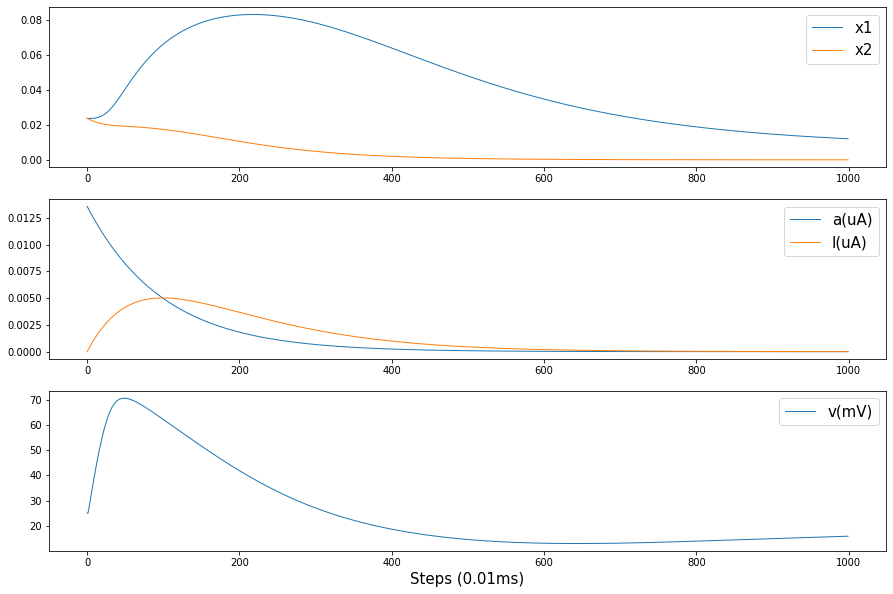

In [31]:
plt.figure(figsize=(15,10))
plt.subplot(311)
plt.plot(range(steps), x1, label='x1', lw = 1)
plt.plot(range(steps), x2, label='x2', lw = 1)
plt.legend(fontsize=15)
plt.subplot(312)
plt.plot(range(steps), a, label='a(uA)', lw = 1)
plt.plot(range(steps), I, label='I(uA)', lw = 1)
plt.legend(fontsize=15)
plt.subplot(313)
plt.plot(range(steps), v, label='v(mV)', lw = 1)
plt.xlabel('Steps (0.01ms)', fontsize=15)
plt.legend(fontsize=15)